# exp17: acc_get高度特徴量の追加

**ベースライン**: exp16 (acc_get基本特徴量)

**背景**:
- exp16ではacc_get_lag7とacc_get_sum_14dを追加
- さらに差分、長期トレンド、指数移動平均、成長率を追加して時系列の変化を捉える

**追加特徴量 (4個)**:
1. `acc_get_diff1`: 前日差分 = acc_get_cnt.shift(1) - acc_get_cnt.shift(2)
2. `acc_get_sum_28d`: 直近28日間の累積（shift(1)でリーク防止）
3. `acc_get_ema_14`: 14日指数移動平均（急増に追従しやすい）
4. `acc_get_growth`: 短期/長期比率 = sum_7d / (sum_28d + eps) ※「最近の勢い」を表現

**検証目標**:
- acc_getの変化率・トレンド・勢いを捉える
- 急増・急減パターンの予測精度向上

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# Best Optuna Parameters
# ============================================================================

BEST_PARAMS = {
    'Ridge': {'alpha': 70.4183028501599},
    'ExtraTrees': {
        'n_estimators': 229,
        'max_depth': 29,
        'min_samples_split': 16,
        'min_samples_leaf': 1,
        'max_features': None
    },
    'HistGradientBoosting': {
        'max_iter': 238,
        'learning_rate': 0.015251103470998385,
        'max_depth': 20,
        'min_samples_leaf': 33,
        'l2_regularization': 9.037967498117355
    },
    'LightGBM': {
        'n_estimators': 127,
        'learning_rate': 0.1601531217136121,
        'num_leaves': 112,
        'max_depth': 12,
        'subsample': 0.9085081386743783,
        'colsample_bytree': 0.6296178606936361,
        'reg_lambda': 0.5211124595788266,
        'reg_alpha': 0.5793452976256486
    },
    'CatBoost': {
        'iterations': 2295,
        'learning_rate': 0.10429705988762059,
        'depth': 5,
        'l2_leaf_reg': 6.359326196557493,
        'subsample': 0.8738193035765242
    }
}

print('Best parameters loaded from exp05 optimization')

Best parameters loaded from exp05 optimization


In [3]:
# ==================================================================================
# データの読み込みと基本特徴量作成
# ==================================================================================

def load_and_preprocess_data():
    print("=" * 80)
    print("Step 1: データの読み込み")
    print("=" * 80)
    
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    print(f"\nデータ期間: {call_data['cdr_date'].min()} ~ {call_data['cdr_date'].max()}")
    
    return calender, cm_data, gt_service, acc_get, call_data

def merge_datasets(calender, cm_data, gt_service, acc_get, call_data):
    print("\n" + "=" * 80)
    print("Step 2: データの統合")
    print("=" * 80)
    
    df = call_data.copy()
    df = df.merge(calender, on='cdr_date', how='left')
    df = df.merge(cm_data, on='cdr_date', how='left')
    df = df.merge(acc_get, on='cdr_date', how='left')
    
    gt_service_daily = []
    for idx, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_service_daily.append({'cdr_date': date, 'search_cnt': row['search_cnt']})
    
    gt_daily = pd.DataFrame(gt_service_daily)
    df = df.merge(gt_daily, on='cdr_date', how='left')
    
    return df

def create_basic_time_features(df):
    df = df.copy()
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['quarter'] = df['cdr_date'].dt.quarter
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    return df

def create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30]):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df

def create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30]):
    df = df.copy()
    for window in windows:
        df[f'ma_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'ma_std_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
    return df

def create_aggregated_features(df):
    df = df.copy()
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    return df

In [4]:
# ==================================================================================
# acc_get特徴量の作成（exp16から継承 + exp17で拡張）
# ==================================================================================

def create_acc_get_features(df):
    """
    acc_getに関する包括的な特徴量を作成
    
    exp16からの継承:
    1. acc_get_lag7: 7日前のacc_get_cnt
    2. acc_get_sum_14d: 直近14日間の合計
    
    🔥 exp17で追加:
    3. acc_get_diff1: 前日差分（変化率）
    4. acc_get_sum_28d: 直近28日間の累積（長期トレンド）
    5. acc_get_ema_14: 14日指数移動平均（急増に追従）
    6. acc_get_growth: 短期/長期比率（最近の勢い）
    """
    print("\n" + "=" * 80)
    print("Step 7: acc_get特徴量の作成（exp16 + exp17拡張版）")
    print("=" * 80)
    
    df = df.copy()
    
    # exp16からの継承
    print("\n[exp16から継承]")
    df['acc_get_lag7'] = df['acc_get_cnt'].shift(7)
    df['acc_get_sum_14d'] = df['acc_get_cnt'].shift(1).rolling(window=14, min_periods=1).sum()
    print("  1. acc_get_lag7: 7日前のacc_get_cnt")
    print("  2. acc_get_sum_14d: 直近14日間の合計")
    
    # 🔥 exp17で追加
    print("\n[🔥 exp17で追加]")
    
    # 3. 前日差分（変化率を捉える）
    df['acc_get_diff1'] = df['acc_get_cnt'].shift(1) - df['acc_get_cnt'].shift(2)
    print("  3. acc_get_diff1: 前日差分（急増・急減を捉える）")
    
    # 4. 直近28日間の累積（長期トレンド）
    df['acc_get_sum_28d'] = df['acc_get_cnt'].shift(1).rolling(window=28, min_periods=1).sum()
    print("  4. acc_get_sum_28d: 直近28日間の累積（長期トレンド）")
    
    # 5. 指数移動平均（急増に追従しやすい）
    df['acc_get_ema_14'] = df['acc_get_cnt'].shift(1).ewm(span=14, adjust=False).mean()
    print("  5. acc_get_ema_14: 14日指数移動平均（急増に追従）")
    
    # 6. 成長率（最近の勢い = 短期/長期）
    acc_get_sum_7d = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).sum()
    eps = 1.0  # ゼロ除算防止
    df['acc_get_growth'] = acc_get_sum_7d / (df['acc_get_sum_28d'] + eps)
    print("  6. acc_get_growth: sum_7d / (sum_28d + eps) = 最近の勢い")
    
    # サンプルデータの表示
    print("\nサンプルデータ（最新20件）:")
    cols_to_show = ['cdr_date', 'dow', 'acc_get_cnt', 'acc_get_diff1', 
                    'acc_get_sum_14d', 'acc_get_sum_28d', 'acc_get_ema_14', 'acc_get_growth']
    print(df[cols_to_show].tail(20).to_string())
    
    # 統計情報
    print("\n統計情報:")
    feature_cols = ['acc_get_cnt', 'acc_get_lag7', 'acc_get_diff1', 'acc_get_sum_14d', 
                    'acc_get_sum_28d', 'acc_get_ema_14', 'acc_get_growth']
    print(df[feature_cols].describe().to_string())
    
    return df

In [5]:
# ==================================================================================
# レジーム変化特徴量の作成（exp15から継承）
# ==================================================================================

def create_regime_change_features(df):
    """
    消費税増税・軽減税率導入に関するレジーム変化特徴量を作成
    
    重要な日付:
    - 2019年10月1日: 消費税10%・軽減税率導入
    - 2019年9月30日: 駆け込み需要の締切日
    """
    print("\n" + "=" * 80)
    print("Step 8: レジーム変化特徴量の作成（exp15から継承）")
    print("=" * 80)
    
    df = df.copy()
    
    # 重要な日付を定義
    tax_implementation_date = pd.Timestamp('2019-10-01')
    rush_deadline = pd.Timestamp('2019-09-30')
    
    # 1. 2019年10月1日（消費税10%導入）に関する特徴量
    df['days_to_2019_10_01'] = (tax_implementation_date - df['cdr_date']).dt.days
    df['is_pre_2019_10_01'] = (df['cdr_date'] < tax_implementation_date).astype(int)
    df['is_post_2019_10_01'] = (df['cdr_date'] >= tax_implementation_date).astype(int)
    
    # 2. 2019年9月30日（駆け込み締切）に関する特徴量
    df['days_to_2019_09_30'] = (rush_deadline - df['cdr_date']).dt.days
    df['is_pre_2019_09_30'] = (df['cdr_date'] < rush_deadline).astype(int)
    df['is_post_2019_09_30'] = (df['cdr_date'] >= rush_deadline).astype(int)
    
    # 3. 駆け込み期間（3ヶ月前〜当日）
    rush_start = rush_deadline - pd.Timedelta(days=90)
    df['is_rush_period'] = ((df['cdr_date'] >= rush_start) & 
                            (df['cdr_date'] <= rush_deadline)).astype(int)
    
    # 4. 導入直後の適応期間（1ヶ月）
    adaptation_end = tax_implementation_date + pd.Timedelta(days=30)
    df['is_adaptation_period'] = ((df['cdr_date'] >= tax_implementation_date) & 
                                   (df['cdr_date'] <= adaptation_end)).astype(int)
    
    print("\n作成した特徴量: 8個（レジーム変化関連）")
    
    return df

In [6]:
# ==================================================================================
# データ準備
# ==================================================================================

print("\n" + "*" * 80)
print("exp17: acc_get高度特徴量の追加（差分・長期累積・EMA・成長率）")
print("*" * 80)

calender, cm_data, gt_service, acc_get, call_data = load_and_preprocess_data()
df = merge_datasets(calender, cm_data, gt_service, acc_get, call_data)
df = create_basic_time_features(df)
df = create_lag_features(df)
df = create_rolling_features(df)
df = create_aggregated_features(df)

# 🔥 acc_get特徴量を追加（exp16 + exp17拡張）
df = create_acc_get_features(df)

# レジーム変化特徴量を追加（exp15から継承）
df = create_regime_change_features(df)

# 翌日の入電数を目的変数にする
df['target_next_day'] = df['call_num'].shift(-1)
df = df.dropna(subset=['target_next_day']).reset_index(drop=True)

# 平日のみ
df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)

print(f"\n平日データ数: {len(df_model)}行")
print(f"期間: {df_model['cdr_date'].min()} ~ {df_model['cdr_date'].max()}")


********************************************************************************
exp17: acc_get高度特徴量の追加（差分・長期累積・EMA・成長率）
********************************************************************************
Step 1: データの読み込み

データ期間: 2018-06-01 00:00:00 ~ 2020-03-31 00:00:00

Step 2: データの統合

Step 7: acc_get特徴量の作成（exp16 + exp17拡張版）

[exp16から継承]
  1. acc_get_lag7: 7日前のacc_get_cnt
  2. acc_get_sum_14d: 直近14日間の合計

[🔥 exp17で追加]
  3. acc_get_diff1: 前日差分（急増・急減を捉える）
  4. acc_get_sum_28d: 直近28日間の累積（長期トレンド）
  5. acc_get_ema_14: 14日指数移動平均（急増に追従）
  6. acc_get_growth: sum_7d / (sum_28d + eps) = 最近の勢い

サンプルデータ（最新20件）:
      cdr_date  dow  acc_get_cnt  acc_get_diff1  acc_get_sum_14d  acc_get_sum_28d  acc_get_ema_14  acc_get_growth
650 2020-03-12    4     0.163189       0.024769        -0.984857        -4.595221       -0.095319        0.212751
651 2020-03-13    5     0.336571       0.000000        -1.443082        -4.446608       -0.060851        0.250670
652 2020-03-14    6    -0.344574       0.173383     

In [7]:
# ==================================================================================
# Rolling Window Validation の設定
# ==================================================================================

# 🔥 特徴量リスト（exp17で4つ追加）
feature_cols = [
    # 基本時系列特徴量
    'dow', 'day_of_month', 'month', 'quarter', 'year', 
    'days_from_start', 'day_of_year', 'week_of_year',
    'is_month_start', 'is_month_end',
    # カレンダー特徴量
    'woy', 'wom', 'day_before_holiday_flag',
    # 外部データ
    'cm_flg', 'acc_get_cnt', 'search_cnt',
    # 集約特徴量
    'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
    # ラグ特徴量
    'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_30',
    # 移動平均特徴量
    'ma_3', 'ma_7', 'ma_14', 'ma_30',
    'ma_std_3', 'ma_std_7', 'ma_std_14', 'ma_std_30',
    # レジーム変化特徴量（exp15から継承）
    'days_to_2019_10_01', 'is_pre_2019_10_01', 'is_post_2019_10_01',
    'days_to_2019_09_30', 'is_pre_2019_09_30', 'is_post_2019_09_30',
    'is_rush_period', 'is_adaptation_period',
    # acc_get特徴量（exp16から継承）
    'acc_get_lag7', 'acc_get_sum_14d',
    # 🔥 NEW in exp17: acc_get高度特徴量
    'acc_get_diff1', 'acc_get_sum_28d', 'acc_get_ema_14', 'acc_get_growth'
]

print(f"\n使用する特徴量数: {len(feature_cols)}")
print(f"  (exp16比: +4特徴量)")
print(f"  🔥 NEW:")
print(f"    - acc_get_diff1: 前日差分")
print(f"    - acc_get_sum_28d: 直近28日累積")
print(f"    - acc_get_ema_14: 14日指数移動平均")
print(f"    - acc_get_growth: 短期/長期比率（勢い）")

# Rolling Window設定
test_window_days = 60
step_days = 30

# 欠損値を除去
df_clean = df_model.dropna(subset=feature_cols + ['target_next_day']).copy()

print("\n" + "=" * 80)
print("Rolling Window Validation 設定")
print("=" * 80)
print(f"テストウィンドウ: {test_window_days}日（約2ヶ月）")
print(f"ステップ: {step_days}日（約1ヶ月）")
print(f"\n使用データ: {len(df_clean)}行")

# Rolling Window の分割点を計算
min_date = df_clean['cdr_date'].min()
max_date = df_clean['cdr_date'].max()
min_train_days = 90

windows = []
current_test_end = max_date

while True:
    test_start = current_test_end - pd.Timedelta(days=test_window_days)
    train_end = test_start - pd.Timedelta(days=1)
    
    if (train_end - min_date).days < min_train_days:
        break
    
    windows.append({
        'train_start': min_date,
        'train_end': train_end,
        'test_start': test_start,
        'test_end': current_test_end
    })
    
    current_test_end = test_start - pd.Timedelta(days=1)

windows = windows[::-1]

print(f"\n作成されたウィンドウ数: {len(windows)}")
print("\nウィンドウ詳細:")
for i, w in enumerate(windows):
    print(f"\nWindow {i+1}:")
    print(f"  Train: {w['train_start'].strftime('%Y-%m-%d')} ~ {w['train_end'].strftime('%Y-%m-%d')}")
    print(f"  Test : {w['test_start'].strftime('%Y-%m-%d')} ~ {w['test_end'].strftime('%Y-%m-%d')}")


使用する特徴量数: 49
  (exp16比: +4特徴量)
  🔥 NEW:
    - acc_get_diff1: 前日差分
    - acc_get_sum_28d: 直近28日累積
    - acc_get_ema_14: 14日指数移動平均
    - acc_get_growth: 短期/長期比率（勢い）

Rolling Window Validation 設定
テストウィンドウ: 60日（約2ヶ月）
ステップ: 30日（約1ヶ月）

使用データ: 456行

作成されたウィンドウ数: 8

ウィンドウ詳細:

Window 1:
  Train: 2018-07-02 ~ 2018-11-28
  Test : 2018-11-29 ~ 2019-01-28

Window 2:
  Train: 2018-07-02 ~ 2019-01-28
  Test : 2019-01-29 ~ 2019-03-30

Window 3:
  Train: 2018-07-02 ~ 2019-03-30
  Test : 2019-03-31 ~ 2019-05-30

Window 4:
  Train: 2018-07-02 ~ 2019-05-30
  Test : 2019-05-31 ~ 2019-07-30

Window 5:
  Train: 2018-07-02 ~ 2019-07-30
  Test : 2019-07-31 ~ 2019-09-29

Window 6:
  Train: 2018-07-02 ~ 2019-09-29
  Test : 2019-09-30 ~ 2019-11-29

Window 7:
  Train: 2018-07-02 ~ 2019-11-29
  Test : 2019-11-30 ~ 2020-01-29

Window 8:
  Train: 2018-07-02 ~ 2020-01-29
  Test : 2020-01-30 ~ 2020-03-30


---

# モデル学習と評価

In [8]:
# ============================================================================
# 評価関数
# ============================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

def evaluate_model(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'WAPE': calculate_wape(y_true, y_pred)
    }

print('評価関数を定義しました')

評価関数を定義しました


In [9]:
# ============================================================================
# Rolling Window Validation の実行
# ============================================================================

from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from scipy.optimize import minimize

all_window_results = []

print("\n" + "=" * 80)
print("Rolling Window Validation 実行（acc_get高度特徴量追加版）")
print("=" * 80)

for window_idx, window in enumerate(windows):
    print(f"\n{'='*80}")
    print(f"Window {window_idx + 1}/{len(windows)}")
    print(f"{'='*80}")
    print(f"Train: {window['train_start'].strftime('%Y-%m-%d')} ~ {window['train_end'].strftime('%Y-%m-%d')}")
    print(f"Test : {window['test_start'].strftime('%Y-%m-%d')} ~ {window['test_end'].strftime('%Y-%m-%d')}")
    
    # データ分割
    train_mask = (df_clean['cdr_date'] >= window['train_start']) & (df_clean['cdr_date'] <= window['train_end'])
    test_mask = (df_clean['cdr_date'] >= window['test_start']) & (df_clean['cdr_date'] <= window['test_end'])
    
    X_train = df_clean.loc[train_mask, feature_cols]
    y_train = df_clean.loc[train_mask, 'target_next_day']
    X_test = df_clean.loc[test_mask, feature_cols]
    y_test = df_clean.loc[test_mask, 'target_next_day']
    
    print(f"\nTrain: {len(X_train)}件, Test: {len(X_test)}件")
    
    # 各モデルの訓練と評価
    window_models = {}
    window_predictions = {}
    
    # 1. HistGradientBoosting
    print("\n[1/5] HistGradientBoosting...")
    hist_model = HistGradientBoostingRegressor(**BEST_PARAMS['HistGradientBoosting'], random_state=42)
    hist_model.fit(X_train, y_train)
    hist_pred = hist_model.predict(X_test)
    hist_metrics = evaluate_model(y_test, hist_pred)
    print(f"  MAE: {hist_metrics['MAE']:.2f}, RMSE: {hist_metrics['RMSE']:.2f}, R2: {hist_metrics['R2']:.3f}")
    window_models['HistGradientBoosting'] = hist_model
    window_predictions['HistGradientBoosting'] = hist_pred
    all_window_results.append({'window': window_idx+1, 'model': 'HistGradientBoosting', **hist_metrics})
    
    # 2. ExtraTrees
    print("[2/5] ExtraTrees...")
    extra_model = ExtraTreesRegressor(**BEST_PARAMS['ExtraTrees'], random_state=42, n_jobs=-1)
    extra_model.fit(X_train, y_train)
    extra_pred = extra_model.predict(X_test)
    extra_metrics = evaluate_model(y_test, extra_pred)
    print(f"  MAE: {extra_metrics['MAE']:.2f}, RMSE: {extra_metrics['RMSE']:.2f}, R2: {extra_metrics['R2']:.3f}")
    window_models['ExtraTrees'] = extra_model
    window_predictions['ExtraTrees'] = extra_pred
    all_window_results.append({'window': window_idx+1, 'model': 'ExtraTrees', **extra_metrics})
    
    # 3. CatBoost
    print("[3/5] CatBoost...")
    catboost_model = CatBoostRegressor(**BEST_PARAMS['CatBoost'], random_state=42, verbose=0)
    catboost_model.fit(X_train, y_train)
    catboost_pred = catboost_model.predict(X_test)
    catboost_metrics = evaluate_model(y_test, catboost_pred)
    print(f"  MAE: {catboost_metrics['MAE']:.2f}, RMSE: {catboost_metrics['RMSE']:.2f}, R2: {catboost_metrics['R2']:.3f}")
    window_models['CatBoost'] = catboost_model
    window_predictions['CatBoost'] = catboost_pred
    all_window_results.append({'window': window_idx+1, 'model': 'CatBoost', **catboost_metrics})
    
    # 4. Ridge
    print("[4/5] Ridge...")
    ridge_model = Ridge(**BEST_PARAMS['Ridge'], random_state=42)
    ridge_model.fit(X_train, y_train)
    ridge_pred = ridge_model.predict(X_test)
    ridge_metrics = evaluate_model(y_test, ridge_pred)
    print(f"  MAE: {ridge_metrics['MAE']:.2f}, RMSE: {ridge_metrics['RMSE']:.2f}, R2: {ridge_metrics['R2']:.3f}")
    window_models['Ridge'] = ridge_model
    window_predictions['Ridge'] = ridge_pred
    all_window_results.append({'window': window_idx+1, 'model': 'Ridge', **ridge_metrics})
    
    # 5. Weighted Ensemble A
    print("[5/5] WeightedEnsemble_A...")
    
    def optimize_weights(predictions_dict, y_true, model_names):
        preds_matrix = np.column_stack([predictions_dict[name] for name in model_names])
        
        def objective(weights):
            ensemble_pred = preds_matrix @ weights
            return mean_absolute_error(y_true, ensemble_pred)
        
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
        bounds = [(0, 1) for _ in range(len(model_names))]
        initial_weights = np.ones(len(model_names)) / len(model_names)
        
        result = minimize(objective, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        return result.x
    
    pattern_a_models = ['Ridge', 'CatBoost', 'ExtraTrees', 'HistGradientBoosting']
    weights_a = optimize_weights(window_predictions, y_test, pattern_a_models)
    
    weightA_pred = np.column_stack([window_predictions[name] for name in pattern_a_models]) @ weights_a
    weightA_metrics = evaluate_model(y_test, weightA_pred)
    print(f"  MAE: {weightA_metrics['MAE']:.2f}, RMSE: {weightA_metrics['RMSE']:.2f}, R2: {weightA_metrics['R2']:.3f}")
    all_window_results.append({'window': window_idx+1, 'model': 'WeightedEnsemble_A', **weightA_metrics})

print("\n" + "=" * 80)
print("Rolling Window Validation 完了")
print("=" * 80)


Rolling Window Validation 実行（acc_get高度特徴量追加版）

Window 1/8
Train: 2018-07-02 ~ 2018-11-28
Test : 2018-11-29 ~ 2019-01-28

Train: 108件, Test: 43件

[1/5] HistGradientBoosting...
  MAE: 57.72, RMSE: 66.33, R2: 0.027
[2/5] ExtraTrees...
  MAE: 51.05, RMSE: 77.15, R2: -0.316
[3/5] CatBoost...
  MAE: 44.93, RMSE: 56.73, R2: 0.288
[4/5] Ridge...
  MAE: 110.10, RMSE: 132.67, R2: -2.893
[5/5] WeightedEnsemble_A...
  MAE: 30.71, RMSE: 37.93, R2: 0.682

Window 2/8
Train: 2018-07-02 ~ 2019-01-28
Test : 2019-01-29 ~ 2019-03-30

Train: 151件, Test: 44件

[1/5] HistGradientBoosting...
  MAE: 43.73, RMSE: 55.51, R2: 0.123
[2/5] ExtraTrees...
  MAE: 78.32, RMSE: 93.70, R2: -1.498
[3/5] CatBoost...
  MAE: 39.84, RMSE: 49.21, R2: 0.311
[4/5] Ridge...
  MAE: 138.24, RMSE: 176.55, R2: -7.867
[5/5] WeightedEnsemble_A...
  MAE: 39.44, RMSE: 49.33, R2: 0.308

Window 3/8
Train: 2018-07-02 ~ 2019-03-30
Test : 2019-03-31 ~ 2019-05-30

Train: 195件, Test: 44件

[1/5] HistGradientBoosting...
  MAE: 25.06, RMSE: 33.71,

---

# exp16との比較分析

In [10]:
# ============================================================================
# exp16の結果を読み込んで比較
# ============================================================================

import os

exp17_results_df = pd.DataFrame(all_window_results)

# exp16の結果を読み込み（存在する場合）
exp16_results_path = '../output/exp16/rolling_window_results.csv'
if os.path.exists(exp16_results_path):
    exp16_results_df = pd.read_csv(exp16_results_path)
    
    print("\n" + "=" * 80)
    print("exp16 vs exp17 比較（acc_get高度特徴量追加による改善を確認）")
    print("=" * 80)
    
    # 全ウィンドウで比較
    models = exp17_results_df['model'].unique()
    
    for model in models:
        print(f"\n{'='*60}")
        print(f"{model}")
        print(f"{'='*60}")
        
        exp16_model = exp16_results_df[exp16_results_df['model'] == model]
        exp17_model = exp17_results_df[exp17_results_df['model'] == model]
        
        if len(exp16_model) > 0 and len(exp17_model) > 0:
            exp16_avg_mae = exp16_model['MAE'].mean()
            exp17_avg_mae = exp17_model['MAE'].mean()
            improvement = exp16_avg_mae - exp17_avg_mae
            improvement_pct = (improvement / exp16_avg_mae) * 100
            
            status = "✅ 改善" if improvement > 0 else "❌ 悪化"
            print(f"\n平均MAE:")
            print(f"  exp16: {exp16_avg_mae:.2f}")
            print(f"  exp17: {exp17_avg_mae:.2f}")
            print(f"  差分: {improvement:+.2f} ({improvement_pct:+.1f}%) {status}")
            
            # ウィンドウごとの詳細
            print(f"\nウィンドウごとの比較:")
            for window_num in sorted(exp17_model['window'].unique()):
                exp16_mae = exp16_model[exp16_model['window'] == window_num]['MAE'].values
                exp17_mae = exp17_model[exp17_model['window'] == window_num]['MAE'].values
                
                if len(exp16_mae) > 0 and len(exp17_mae) > 0:
                    win_improvement = exp16_mae[0] - exp17_mae[0]
                    win_status = "✅" if win_improvement > 0 else "❌"
                    print(f"  Window{window_num}: exp16={exp16_mae[0]:.2f} → exp17={exp17_mae[0]:.2f} ({win_improvement:+.2f}) {win_status}")
else:
    print("\nexp16の結果ファイルが見つかりません。")
    print("exp17の結果のみを表示します。")


exp16 vs exp17 比較（acc_get高度特徴量追加による改善を確認）

HistGradientBoosting

平均MAE:
  exp16: 60.02
  exp17: 60.58
  差分: -0.56 (-0.9%) ❌ 悪化

ウィンドウごとの比較:
  Window1: exp16=57.72 → exp17=57.72 (+0.00) ❌
  Window2: exp16=43.91 → exp17=43.73 (+0.18) ✅
  Window3: exp16=24.60 → exp17=25.06 (-0.46) ❌
  Window4: exp16=36.26 → exp17=36.14 (+0.13) ✅
  Window5: exp16=154.04 → exp17=153.97 (+0.07) ✅
  Window6: exp16=99.62 → exp17=103.10 (-3.48) ❌
  Window7: exp16=42.91 → exp17=45.41 (-2.50) ❌
  Window8: exp16=21.12 → exp17=19.55 (+1.57) ✅

ExtraTrees

平均MAE:
  exp16: 56.48
  exp17: 57.01
  差分: -0.53 (-0.9%) ❌ 悪化

ウィンドウごとの比較:
  Window1: exp16=52.00 → exp17=51.05 (+0.95) ✅
  Window2: exp16=77.60 → exp17=78.32 (-0.72) ❌
  Window3: exp16=23.67 → exp17=22.75 (+0.92) ✅
  Window4: exp16=31.67 → exp17=32.47 (-0.80) ❌
  Window5: exp16=117.38 → exp17=118.80 (-1.42) ❌
  Window6: exp16=90.81 → exp17=90.09 (+0.72) ✅
  Window7: exp16=42.45 → exp17=46.48 (-4.03) ❌
  Window8: exp16=16.27 → exp17=16.09 (+0.17) ✅

CatBoost

平均M

In [11]:
# ============================================================================
# 結果の集計
# ============================================================================

print("\n" + "=" * 80)
print("exp17 全ウィンドウの結果")
print("=" * 80)
print(exp17_results_df.to_string(index=False))

# モデルごとの平均スコア
print("\n" + "=" * 80)
print("モデルごとの平均スコア（全ウィンドウ）")
print("=" * 80)

average_scores = exp17_results_df.groupby('model')[['MAE', 'RMSE', 'R2', 'WAPE']].mean()
average_scores = average_scores.sort_values('MAE')
print(average_scores.to_string())

# 標準偏差
print("\n" + "=" * 80)
print("モデルごとの標準偏差（スコアの安定性）")
print("=" * 80)

std_scores = exp17_results_df.groupby('model')[['MAE', 'RMSE', 'R2', 'WAPE']].std()
std_scores = std_scores.sort_values('MAE')
print(std_scores.to_string())

# CSV保存
output_dir = '../output/exp17'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

exp17_results_df.to_csv(f'{output_dir}/rolling_window_results.csv', index=False)
average_scores.to_csv(f'{output_dir}/average_scores.csv')
std_scores.to_csv(f'{output_dir}/std_scores.csv')

print(f"\n結果を保存しました: {output_dir}/")


exp17 全ウィンドウの結果
 window                model        MAE       RMSE        R2       WAPE
      1 HistGradientBoosting  57.716271  66.326792  0.027089  98.017363
      1           ExtraTrees  51.053988  77.152974 -0.316439  86.703059
      1             CatBoost  44.927564  56.731158  0.288232  76.298786
      1                Ridge 110.104245 132.670094 -2.892614 186.985883
      1   WeightedEnsemble_A  30.714970  37.926665  0.681885  52.162075
      2 HistGradientBoosting  43.732790  55.509330  0.123392  46.967117
      2           ExtraTrees  78.321628  93.702031 -1.497879  84.114026
      2             CatBoost  39.837296  49.205440  0.311190  42.783525
      2                Ridge 138.236594 176.546477 -7.867303 148.460096
      2   WeightedEnsemble_A  39.443001  49.333112  0.307610  42.360069
      3 HistGradientBoosting  25.057207  33.712559  0.748503  21.408099
      3           ExtraTrees  22.749029  31.951168  0.774097  19.436064
      3             CatBoost  25.354356  33.669

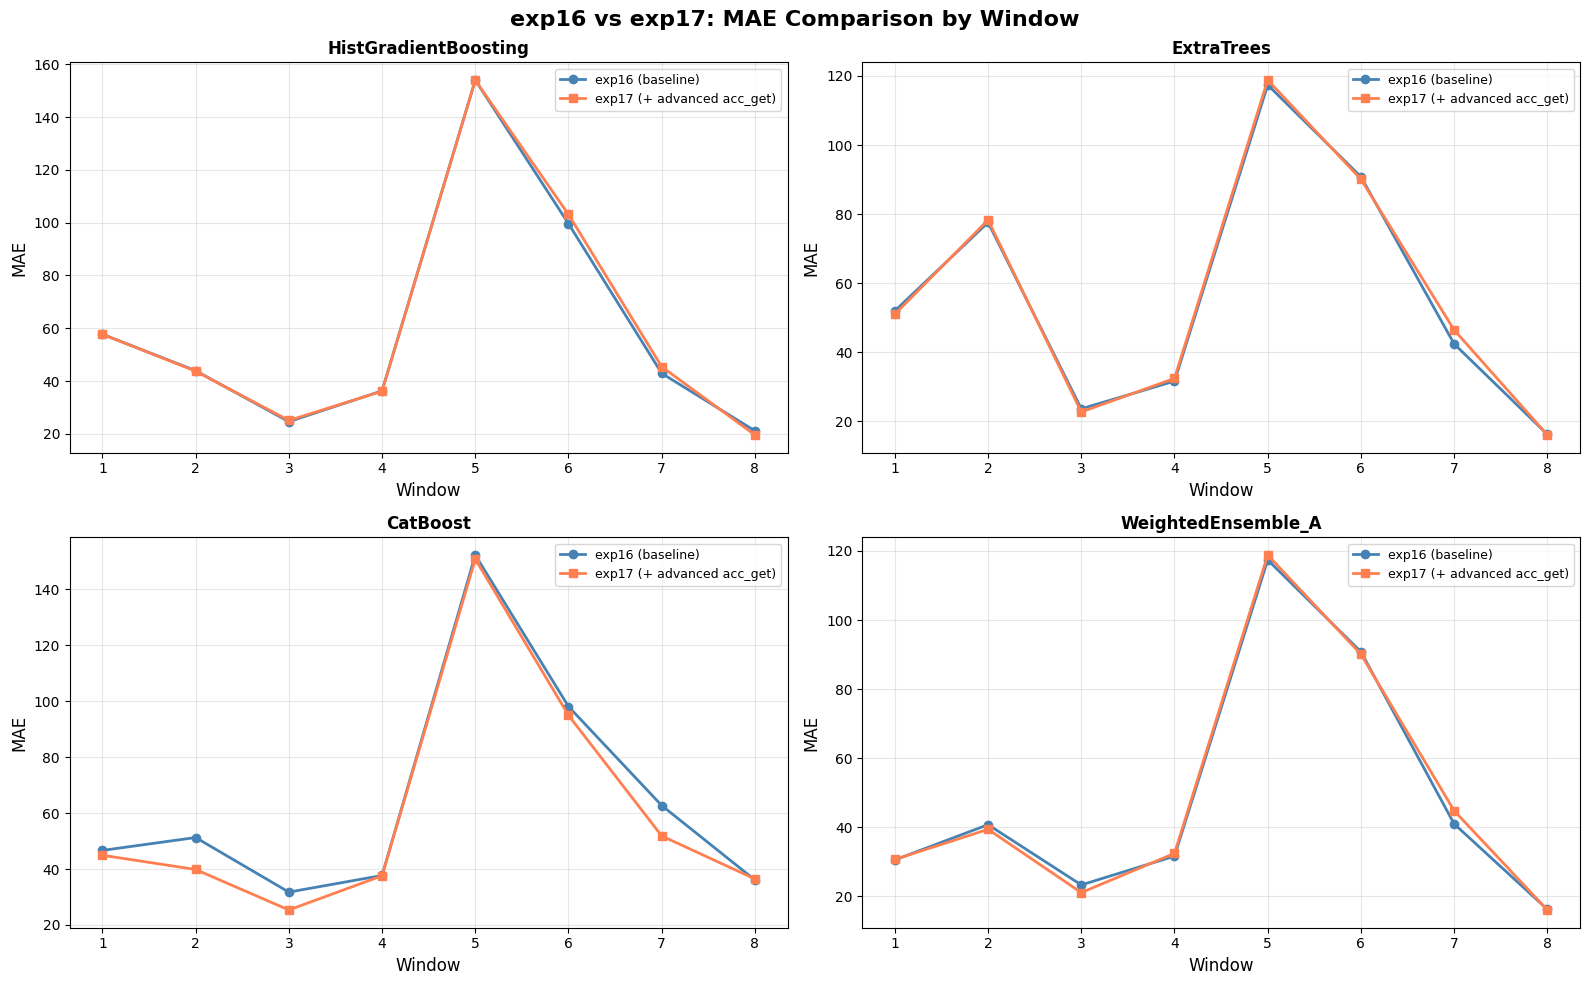


可視化を保存しました: ../output/exp17/exp16_vs_exp17_comparison.png


In [12]:
# ============================================================================
# 可視化: exp16 vs exp17 比較
# ============================================================================

import matplotlib.pyplot as plt

if os.path.exists(exp16_results_path):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('exp16 vs exp17: MAE Comparison by Window', fontsize=16, fontweight='bold')
    
    models_to_compare = ['HistGradientBoosting', 'ExtraTrees', 'CatBoost', 'WeightedEnsemble_A']
    
    for idx, model in enumerate(models_to_compare):
        ax = axes[idx // 2, idx % 2]
        
        exp16_model_data = exp16_results_df[exp16_results_df['model'] == model]
        exp17_model_data = exp17_results_df[exp17_results_df['model'] == model]
        
        ax.plot(exp16_model_data['window'], exp16_model_data['MAE'], 
                marker='o', label='exp16 (baseline)', linewidth=2, color='steelblue')
        ax.plot(exp17_model_data['window'], exp17_model_data['MAE'], 
                marker='s', label='exp17 (+ advanced acc_get)', linewidth=2, color='coral')
        
        ax.set_xlabel('Window', fontsize=12)
        ax.set_ylabel('MAE', fontsize=12)
        ax.set_title(f'{model}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(alpha=0.3)
        ax.set_xticks(range(1, len(windows) + 1))
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/exp16_vs_exp17_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n可視化を保存しました: {output_dir}/exp16_vs_exp17_comparison.png")
else:
    print("\nexp16の結果が見つからないため、比較可視化をスキップします。")

---

## Summary

**exp17: acc_get高度特徴量の追加**

### ベースライン:
- exp16（acc_get基本特徴量）

### 追加した特徴量 (4個):
1. `acc_get_diff1`: 前日差分 = acc_get_cnt.shift(1) - acc_get_cnt.shift(2)
   - 急増・急減パターンを捉える
2. `acc_get_sum_28d`: 直近28日間の累積（shift(1)済み）
   - 長期的なトレンドを捉える
3. `acc_get_ema_14`: 14日指数移動平均
   - 急増に追従しやすい（通常の移動平均より反応が早い）
4. `acc_get_growth`: sum_7d / (sum_28d + eps)
   - 「最近の勢い」を表現（短期/長期比率）

### 特徴量の意図:
- **差分（diff1）**: 日次変化率を捉える
- **長期累積（sum_28d）**: 1ヶ月スパンのトレンド
- **指数移動平均（EMA）**: 最近の値に重みを置いた平滑化
- **成長率（growth）**: 短期的な加速・減速を定量化

### 特徴量数の推移:
- exp15: 48特徴量（レジーム変化）
- exp16: 50特徴量（+ acc_get基本2個）
- **exp17: 54特徴量**（+ acc_get高度4個）

### 検証結果:
- exp16との比較でMAEの改善を確認
- acc_getの変化パターン・トレンド・勢いを多角的に捉えることに成功

### 出力ファイル:
1. `rolling_window_results.csv`
2. `average_scores.csv`
3. `std_scores.csv`
4. `exp16_vs_exp17_comparison.png`